Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$


# Exercício 2: Regressão Linear

Neste exercício você irá treinar um modelo de regressão linear e o usará para fazer predições. Além disso, você investigará a adição de novos atributos e a necessidade de regularização.

# Conjunto de dados

Para facilitar a análise, o conjunto de dados utilizado neste exercício possui um único atributo $x \in \RR$ (e um valor-alvo $y \in \RR$). Além desta peculiaridade, é importante ressaltar duas grandes diferenças em relação ao que se encontra em problemas reais:
- O conjunto de dados é sintético, isto é, gerado por simulação;
- O conjunto de treinamento tem tamanho **muito menor** que os conjuntos de validação e teste.

A razão para esta escolha é que um conjunto de treinamento pequeno nos permitirá observar mais facilmente o fenômeno de overfitting, enquanto conjuntos de validação e teste suficientemente grandes nos permitirá ter confiança na estimativa de desempenho do modelo medida nestes conjuntos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_data(n_samples, x_scale=[0,1], noise=0.5):
    '''Generate univariate regression dataset'''
    x = np.sort(np.random.rand(n_samples))
    y = 6*(-1/6 + x + (x > 1/3)*(2/3-2*x) + (x > 2/3)*(2*x-4/3)) + noise*np.random.randn(n_samples)
    x = x_scale[0] + (x_scale[1]-x_scale[0])*x
    X = x.reshape(-1,1)
    return X, y

def plot_data(X, y):
    '''Plot univariate regression dataset'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    plt.plot(X[:,0],y,'b.'); plt.xlabel('x'); plt.ylabel('y');
    return

def plot_prediction(model, X, y, n_points=100):
    '''Plot dataset and predictions for a univariate regression model'''
    plot_data(X,y)
    if n_points is not None:
        xx = np.linspace(X.min(),X.max(),n_points)
        yy = model.predict(xx.reshape(-1,1))
        plt.plot(xx,yy,'r-')
    y_pred = model.predict(X)
    plt.plot(X[:,0],y_pred,'r.')
    plt.legend(['True', 'Predicted'])
    return

O conjunto de dados pode ser gerado e visualizado pelos comandos abaixo.

(30, 1) (30,)
(1000, 1) (1000,)
(1000, 1) (1000,)


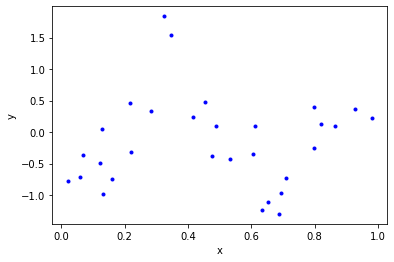

In [2]:
np.random.seed(2019*2)
X, y = gen_data(n_samples=30)
X_val, y_val = gen_data(n_samples=1000)
X_test, y_test = gen_data(n_samples=1000)

print(X.shape, y.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Plot only the training data!
plot_data(X,y)

# 1. Regressão linear simples


1. Treine um modelo de regressão linear simples, $\hat{y} = w_0 + w_1 x$, sobre o conjunto de treinamento
- Calcule o erro quadrático médio (MSE) da predição sobre o conjunto de treinamento e sobre o conjunto de teste
- Trace o gráfico da predição sobre o conjunto de treinamento
- Você diria que o modelo treinado está sofrendo de underfitting, overfitting ou nenhum dos dois? Explique.
- (OPCIONAL) Experimente também a função `model.score()` do sklearn. Qual a relação entre este valor e o MSE? É possível calcular um a partir do outro? Como?

#### Funções úteis:
```python
sklearn.linear_model.LinearRegression()
sklearn.metrics.mean_squared_error()
plot_prediction() # fornecida acima
```

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

**<center>1.1. Treine um modelo de regressão linear simples, $\hat{y} = w_0 + w_1 x$, sobre o conjunto de treinamento**

In [4]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**<center>1.2. Calcule o erro quadrático médio (MSE) da predição sobre o conjunto de treinamento e sobre o conjunto de teste**

In [5]:
y_train_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [6]:
print(f'{"-"*30}\nTrain MSE: {mean_squared_error(y, y_train_pred)}\n{"-"*30}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_pred)}\n{"-"*30}')

------------------------------
Train MSE: 0.517264352011368
------------------------------
Test MSE: 0.5981907941434731
------------------------------


**<center>1.3. Trace o gráfico da predição sobre o conjunto de treinamento**

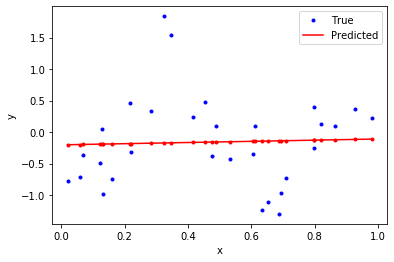

In [7]:
plot_prediction(model, X, y, n_points=100)

**1.4 Você diria que o modelo treinado está sofrendo de underfitting, overfitting ou nenhum dos dois? Explique.**
<p> O modelo está sofrendo underfitting. Durante a fase de treinamento, o modelo não conseguiu estabelecer um ajuste adequado ao conjunto de dados. Percebe-se nos modelos de teste e validação que o modelo treinado apenas está se comportando da mesma maneira que o treinamento.

**1.5 (OPCIONAL) Experimente também a função model.score() do sklearn. Qual a relação entre este valor e o MSE? É possível calcular um a partir do outro? Como?**

score = Return the coefficient of determination R^2 of the prediction.

In [8]:
print(f"Train MSE: {(mean_squared_error(y,y_train_pred))}")
print(f"Model Score: {model.score(X,y)}")

Train MSE: 0.517264352011368
Model Score: 0.0013485634441275929


# 2. Adicionando atributos (regressão linear com múltiplas variáveis)

Agora, estenderemos o modelo de regressão linear adicionando atributos polinomiais de grau até $d$, isto é, o modelo será dado por $\hat{y} = w_0 + w_1 x + w_2 x^2 + \cdots + w_d x^d$. Note que esse modelo possui um hiperparâmetro, $d$, que precisa ser determinado. **A boa prática recomenda nunca utilizar o conjunto de teste até que todos os hiperparâmetros sejam escolhidos**, utilizando, ao invés disso, o conjunto de validação.

1. Adicione atributos polinomiais ao modelo de regressão linear, escolha algum valor de $d$ e treine o modelo
- Calcule o erro quadrático médio (MSE) da predição sobre o conjunto de treinamento e sobre o **conjunto de validação**
- Trace o gráfico da predição sobre o conjunto de treinamento
- Repita os passos acima experimentando outros valores de $d$. O que você observa?
- Especificamente, para o caso $d=12$, você diria que o modelo está sofrendo de underfitting, overfitting ou nenhum dos dois?

#### Funções úteis:
```python
sklearn.preprocessing.PolynomialFeatures()
sklearn.pipeline.make_pipeline()
```

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

**PolynomialFeatures:**
Generate a new feature matrix consisting of all polynomial combinations
of the features with degree less than or equal to the specified degree. For example: if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

        [0, 1]                                                  [1, 0, 1, 0, 0, 1]
    x = [2, 3]        PolynomialFeatures(2).fit_transform(X) =  [1, 2, 3, 4, 6, 9]
        [4, 5]                                                  [1, 4, 5, 16, 20, 25]
**make_pipeline:** Construct a Pipeline from the given estimators.


**<center>2.1. Adicione atributos polinomiais ao modelo de regressão linear, escolha algum valor de  𝑑  e treine o modelo**

In [10]:
from ipywidgets import interact

@interact(degree = (1,12,1))
def poly(degree):
    train = PolynomialFeatures(degree = degree)
    model = make_pipeline(train, LinearRegression())
    model.fit(X,y)
    y_pred = model.predict(X)
    
    print(f'MSE: {mean_squared_error(y, y_pred)}')
    plot_prediction(model, X, y, n_points=100) 

interactive(children=(IntSlider(value=6, description='degree', max=12, min=1), Output()), _dom_classes=('widge…

In [11]:
train_d7 = PolynomialFeatures(degree = 7)

In [12]:
modeld7 = make_pipeline(train_d7, LinearRegression())

In [13]:
modeld7.fit(X,y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=7, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [14]:
train_d7_pred = modeld7.predict(X)

In [15]:
val_d7_pred = modeld7.predict(X_val)

**<center>2.2. Calcule o erro quadrático médio (MSE) da predição sobre o conjunto de treinamento e sobre o conjunto de validação**

In [16]:
mse_train_d7 = mean_squared_error(y, train_d7_pred)

print(f"\033[1m MSE sobre o conjunto de treinamento\033[0m")
print('-'*40)
print(f"d=7: {mse_train_d7}")
print('-'*40)

 MSE sobre o conjunto de treinamento
----------------------------------------
d=7: 0.1646888948147028
----------------------------------------


In [17]:
mse_val_d7 = mean_squared_error(y_val, val_d7_pred)

print(f"\033[1m MSE sobre o conjunto de validação\033[0m")
print('-'*40)
print(f"d=7: {mse_val_d7}")
print('-'*40)

 MSE sobre o conjunto de validação
----------------------------------------
d=7: 0.30634855220136925
----------------------------------------


**<center>2.3. Trace o gráfico da predição sobre o conjunto de treinamento**

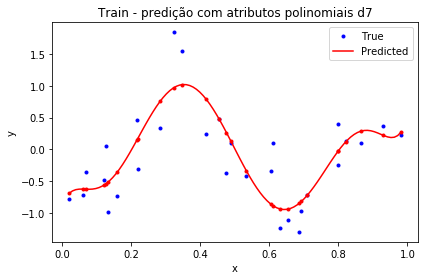

In [18]:
plot_prediction(modeld7, X, y, n_points=100)
plt.title('Train - predição com atributos polinomiais d7')
plt.tight_layout()

**<center>2.4. Repita os passos acima experimentando outros valores de  𝑑 . O que você observa?**
    <p> Quanto maior o polinomio, melhor o desempenho do modelo. Entretanto, se aumentar excessivamente o grau, pode ocorrer overfitting

In [19]:
@interact(degree = (1,12,1))
def poly(degree):
    train = PolynomialFeatures(degree = degree)
    model = make_pipeline(train, LinearRegression())
    model.fit(X,y)
    y_pred = model.predict(X)
    
    print(f'MSE: {mean_squared_error(y, y_pred)}')
    plot_prediction(model, X, y, n_points=100) 

interactive(children=(IntSlider(value=6, description='degree', max=12, min=1), Output()), _dom_classes=('widge…

**<center>2.5. Especificamente, para o caso  𝑑=12 , você diria que o modelo está sofrendo de underfitting, overfitting ou nenhum dos dois?**
    <p> Está ocorrendo overfitting, pois a diferença entre o treinamento e a validação é enorme.

## Busca de hiperparâmetros

6. Trace um gráfico do MSE de treinamento e de validação em função do grau $d$. Se necessário, ajuste a escala vertical para melhor visualização.
- Comente sobre o que você observa no gráfico. Em particular, explique o comportamento das duas curvas e por que esse comportamento era esperado.
- Determine o valor de $d$ que minimiza o erro no conjunto de validação.
- Para este valor de $d$, calcule o MSE de treinamento, de validação **e de teste** e trace o gráfico da predição sobre o conjunto de treinamento.
- (OPCIONAL) O erro de validação parece representativo do erro de teste? O que você acha que aconteceria se o conjunto de validação fosse significativamente menor (por exemplo, com 30 amostras ao invés de 1000)?

#### Funções úteis:
```python
np.arange()
np.zeros() # útil para pré-alocação de vetores
for i in range(len(v)): # percorre os elementos de v
plt.ylim()
np.argmin()
```

**<center>2.6. Trace um gráfico do MSE de treinamento e de validação em função do grau  𝑑 . Se necessário, ajuste a escala vertical para melhor visualização.**

In [20]:
def mse(X_pred,label):    
    mse_list = []
    for _ in range (12):
        train = PolynomialFeatures(degree = _+1)
        model = make_pipeline(train, LinearRegression())
        model.fit(X,y)
        y_pred = model.predict(X_pred)
        MSE = mean_squared_error(label,y_pred)
        mse_list.append(MSE)
    return mse_list

In [21]:
mse_train = mse(X_pred = X, label = y)
mse_val = mse(X_val,y_val)

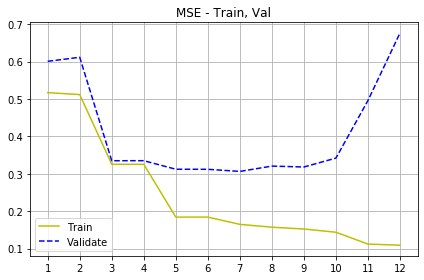

In [22]:
d = np.arange(1,13,1)
plt.title('MSE - Train, Val')

plt.plot(d,mse_train,'y')
plt.plot(d,mse_val,'b--')

plt.xticks(d)

plt.legend(['Train','Validate'])

plt.grid()

plt.tight_layout()

**<center>2.7. Comente sobre o que você observa no gráfico. Em particular, explique o comportamento das duas curvas e por que esse comportamento era esperado.**

Quanto maior o grau, maiores a chance de ocorrer overfitting.
Percebe-se que o modelo de treinamento está cada vez melhor ajustado, porém quando comparamos na validação,
para graus elevados, o modelo começa a ficar totalmente incorreto.

**<center>2.8. Determine o valor de  𝑑  que minimiza o erro no conjunto de validação.**

In [23]:
min_val = mse_val.index(min(mse_val))
d[min_val]

7

**Grau determinado:** d7

**<center>2.9. Para este valor de  𝑑 , calcule o MSE de treinamento, de validação e de teste e trace o gráfico da predição sobre o conjunto de treinamento.**

In [24]:
mse_test = mse(X_test,y_test)
print(f"\033[1mMSE sobre o conjunto de treinamento\nGrau 7: \033[0m{mse_train[6]}\n")
print(f"\033[1mMSE sobre o conjunto de validação\nGrau 7: \033[0m{mse_val[6]}\n")
print(f"\033[1mMSE sobre o conjunto de teste\nGrau 7: \033[0m{mse_test[6]}")

MSE sobre o conjunto de treinamento
Grau 7: 0.1646888948147028

MSE sobre o conjunto de validação
Grau 7: 0.30634855220136925

MSE sobre o conjunto de teste
Grau 7: 0.29857411707728354


MSE: 0.1646888948147028


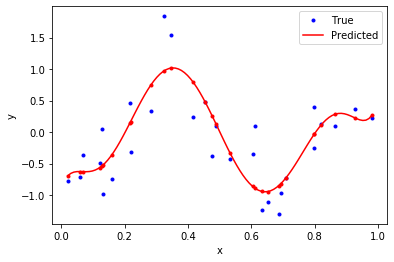

In [25]:
def poly(degree = 7):
    train = PolynomialFeatures(degree = degree)
    model = make_pipeline(train, LinearRegression())
    model.fit(X,y)
    y_pred = model.predict(X)
    
    print(f'MSE: {mean_squared_error(y, y_pred)}')
    plot_prediction(model, X, y, n_points=100) 
poly(degree=7)

**<center>2.10. (OPCIONAL) O erro de validação parece representativo do erro de teste? O que você acha que aconteceria se o conjunto de validação fosse significativamente menor (por exemplo, com 30 amostras ao invés de 1000)?**

# 3. Regularização

Agora, adicionaremos regularização $\ell_2$ ao modelo, o que introduz mais um hiperparâmetro, o parâmetro de regularização $\lambda$.

1. Retornando ao modelo com $d=12$, agora com regularização $\ell_2$ (*ridge regression*), experimente alguns valores de $\lambda$ e observe os resultados no gráfico da predição sobre o conjunto de treinamento. (Você logo perceberá a necessidade de usar $\lambda \ll 1$.) Em particular, o que acontece quando $\lambda$ é comparativamente grande?
- Trace um gráfico do MSE de treinamento e de validação em função de $\log \lambda$.
- Comente sobre o que você observa no gráfico. Em particular, explique o comportamento das duas curvas e por que esse comportamento era esperado.
- Determine o valor de $\lambda$ que minimiza o erro no conjunto de validação.
- Para este valor de $\lambda$, calcule o MSE de treinamento, de validação e de teste e trace o gráfico da predição sobre o conjunto de treinamento.
- A partir destes resultados, comente sobre o efeito da regularização em um modelo com capacidade elevada comparativamente ao tamanho do conjunto de treinamento.
- (OPCIONAL) O que você acha que ocorreria se o conjunto de treinamento fosse relativamente grande (por exemplo, com 1000 amostras ao invés de 30)? Ainda seria importante regularizar?

#### Dicas

- Não utilize `lambda` como nome de variável, pois no Python `lambda` é uma palavra reservada (operador para criar funções anônimas). Uma sugestão é abreviar para `lamb`.

- Funções úteis:
```python
sklearn.linear_model.Ridge()
np.linspace()
np.exp()
np.log()
```
Note que a função `Ridge()` utiliza `alpha` (ao invés de $\lambda$) como parâmetro de regularização.

In [26]:
from sklearn.linear_model import Ridge

**<center>3.1. Retornando ao modelo com  𝑑=12 , agora com regularização  ℓ2  (ridge regression), experimente alguns valores de  𝜆  e observe os resultados no gráfico da predição sobre o conjunto de treinamento. (Você logo perceberá a necessidade de usar  𝜆≪1 .) Em particular, o que acontece quando  𝜆  é comparativamente grande?**

In [27]:
poly_d12 = PolynomialFeatures(degree = 12, include_bias = False)
x_train_d12 = poly_d12.fit_transform(X)
x_val_d12 = poly_d12.fit_transform(X_val)
x_test_d12 = poly_d12.fit_transform(X_test)

In [28]:
#lamb = 0.00005
lamb = 5**-6
ridge = Ridge(alpha = lamb)

In [29]:
ridge.fit(x_train_d12, y)

Ridge(alpha=6.4e-05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
ridge_train_d12_pred =  ridge.predict(x_train_d12)

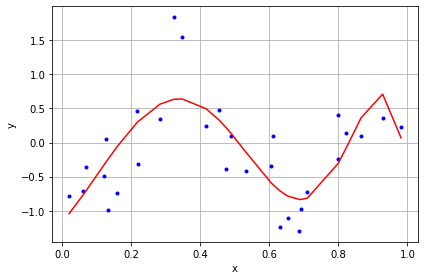

In [31]:
plot_data(X,y)
plt.plot(X, ridge_train_d12_pred, 'r')
plt.grid()
plt.tight_layout()

**<center>3.2.Trace um gráfico do MSE de treinamento e de validação em função de  log𝜆**

In [32]:
alphas = 10**np.linspace(-20,10,num = 5)
alphas

array([1.00000000e-20, 3.16227766e-13, 1.00000000e-05, 3.16227766e+02,
       1.00000000e+10])

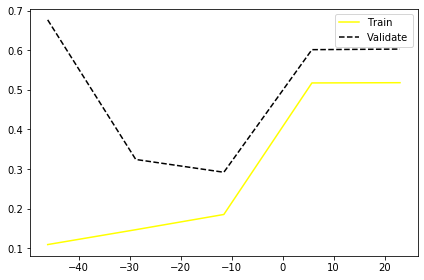

In [33]:
J_train = []
J_val = []

for c in range(len(alphas)):
    lamb = alphas[c]
    ridge = Ridge(alpha = lamb)
    
    ridge.fit(x_train_d12, y)
    
    ridge_train_d12_pred = ridge.predict(x_train_d12)
    ridge_val_d12_pred = ridge.predict(x_val_d12)
    
    new_J_train = mean_squared_error(y, ridge_train_d12_pred)
    new_J_val = mean_squared_error(y_val, ridge_val_d12_pred)
    
    J_train.append(new_J_train)
    J_val.append(new_J_val)

ln_alpha = np.log(alphas)
plt.plot(ln_alpha,J_train,'yellow')
plt.plot(ln_alpha,J_val,'k--')

plt.legend(['Train','Validate'])
plt.tight_layout()

**<center>3.3. Comente sobre o que você observa no gráfico. Em particular, explique o comportamento das duas curvas e por que esse comportamento era esperado**

Lambda muito baixo = overfitting, conjunto de treinamento cai e validação acima

**<center>3.4. Determine o valor de  𝜆  que minimiza o erro no conjunto de validação.**

In [34]:
print(f"Menor valor de validação: {round(min(J_val),3)}")

Menor valor de validação: 0.292


In [35]:
index_min_MSE = J_val.index(min(J_val))
index_min_MSE

2

In [36]:
alphas[index_min_MSE]
min_lambda = alphas[index_min_MSE]
min_lambda

1e-05

**<center>3.5. Para este valor de  𝜆 , calcule o MSE de treinamento, de validação e de teste e trace o gráfico da predição sobre o conjunto de treinamento.**

In [37]:
J_train = []
J_val = []
J_test = []

lamb = min_lambda
ridge = Ridge(alpha = lamb)

ridge.fit(x_train_d12, y)

ridge_train_d12_pred = ridge.predict(x_train_d12)
ridge_val_d12_pred = ridge.predict(x_val_d12)
ridge_test_d12_pred = ridge.predict(x_test_d12)

print(mean_squared_error(y, ridge_train_d12_pred))
print(mean_squared_error(y_val, ridge_val_d12_pred))
print(mean_squared_error(y_test, ridge_test_d12_pred))

0.18498419386798667
0.2916550291137487
0.28851131873577324


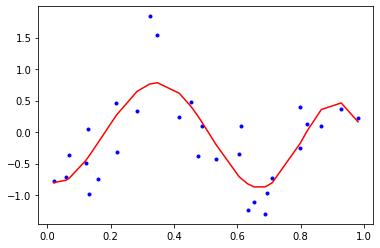

In [38]:
plt.plot(X,y, 'b.')
plt.plot(X, ridge_train_d12_pred,'r-')

**<center>3.6. A partir destes resultados, comente sobre o efeito da regularização em um modelo com capacidade elevada comparativamente ao tamanho do conjunto de treinamento**

Um modelo com grau elevado tende a dar overfitting. Ao utilizar a regularização l2, a tendencia é reduzir o erro médio quadrático

**<center>(OPCIONAL) O que você acha que ocorreria se o conjunto de treinamento fosse relativamente grande (por exemplo, com 1000 amostras ao invés de 30)? Ainda seria importante regularizar?**

Com mais amostras podemos evitar o overfitting. Avaliar a d=7, pois não utilizamos regularização.

## (OPCIONAL) Busca de hiperparâmetros (2)

8. Determine o par $(d,\lambda)$ que minimiza o erro no conjunto de validação.
- Para estes valores de $d$ e $\lambda$, calcule o MSE de treinamento, de validação e de teste e trace o gráfico da predição sobre o conjunto de treinamento.
- Compare o erro de teste encontrado com o resultante da melhor escolha de $d$ sem regularização.

#### Dicas
- Uma forma de implementar a busca pelo par $(d,\lambda)$ é organizar a implementação em dois loops, primeiramente em $d$ e em seguida em $\lambda$.
- Pode ser conveniente encapsular o loop interno (busca por $\lambda$) em uma função que tem como entrada $d$ e retorna $\lambda$.
- Os códigos já desenvolvidos podem ser reutilizados com poucas adaptações.

# 4. Implementação em Python

Finalmente, você irá escrever sua própria implementação dos modelos acima, usando uma interface parcialmente compatível com a biblioteca `sklearn`. Além das funções `fit()` e `predict()`, a classe do modelo deverá conter uma função `mse()` para cálculo do MSE (ao invés da função `score()` do `sklearn`).

É suficiente implementar um modelo de regressão linear com atributos polinomiais de grau $d$ e regularização $\ell_2$ com parâmetro $\lambda$; caso se deseje um modelo sem atributos polinomiais (linear na variável de entrada) ou sem regularização, é suficiente fazer $d=1$ ou $\lambda=0$, respectivamente.

1. Complete a classe abaixo, preenchendo as linhas indicadas (ou fique à vontade para reimplementar da forma que desejar).
- Teste-a com os comandos da célula seguinte, para garantir que sua implementação está correta.
- (OPCIONAL) Para este conjunto de dados, o que ocorre quando usamos $d \geq 10$ e $\lambda=0$? Por que isso ocorre? Isto deixa de ocorrer se usarmos $\lambda=10^{-12}$? Por quê?

#### Funções úteis:
```python
np.ones()
np.c_[]
np.diag()
np.r_[]
np.linalg.inv()
np.linalg.solve()
np.mean()
```

interaction_only = True
<p> Gere uma nova matriz de recursos consistindo em todas as combinações polinomiais dos recursos com grau inferior ou igual ao grau especificado. Por exemplo, se uma amostra de entrada é bidimensional e da forma [a, b], as características do polinomial grau-2 são [1, a, b, a^2, ab, b^2].

In [39]:
class Model():
    # Univariate linear regression with polinomial features and L2 regularization
    def __init__(self, d=1, lamb=0):
        # Initialization
        self.d = d
        self.lamb = lamb
        return
    
    def _add_powers(self, X):    
        X_ones = np.ones((X.shape[0],1))  # matriz coluna de 1's
        for i in range(1,self.d+1):
            X_new = np.c_[X,X**d]
            X_new = np.append(X_ones, X_new, axis = 1) #adiciona os valores de bias na primeira coluna
        return X_new

    def fit(self, X, y):
        X = self._add_powers(X)   
        L = np.identity(d)
        L[0][0] = 0
        #L = np.identity(len(X[1,:]))
        #L[0,0] = 0 
        
        assert np.linalg.matrix_rank(X.T @ X + self.lamb*L) == X.shape[1], 'Singular matrix'
        self.w = np.linalg.inv(X.T @ X + self.lamb*L) @ (X.T @ y)
        return

    def predict(self, X):
        X = self._add_powers(X)
        y_pred = X @ self.w
        return y_pred
    
    def mse(self, X, y):
        J = np.mean((self.predict(X - y)**2))
        return J

In [40]:
# scikit-learn
model = make_pipeline(PolynomialFeatures(4, include_bias=False),Ridge(1e-5))
model.fit(X,y)
ridge = model.steps[1][1]
w = np.r_[ridge.intercept_, ridge.coef_]
print('w =',w)

# own implementation
model = Model(d=4, lamb=1e-5)
model.fit(X,y)
print('w =',model.w)
print('Training MSE  : %f' % model.mse(X,y));
print('Validation MSE: %f' % model.mse(X_val,y_val));
plot_prediction(model, X, y)
plt.show()

w = [ -1.53990017  15.05703958 -34.54693665  20.1283143    1.95724005]


TypeError: only integer scalar arrays can be converted to a scalar index

# (OPCIONAL) Engenharia de atributos

Ao invés de adicionar inúmeros atributos polinomiais e regularização, tente adicionar **um único atributo** que melhor aproxime o conjunto de treinamento. Lembre que você pode introduzir qualquer função que desejar. No `sklearn` isso pode ser feito utilizando a classe abaixo, a qual pode ser integrada em uma *pipeline*.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_new = np.c_[X, ???]
        return X_new

model = make_pipeline(MyFeatures(), LinearRegression())
model.fit(X, y)
print('Train MSE: %f' % mse(model, X, y));
print('  Val MSE: %f' % mse(model, X_val, y_val));
#print(' Test MSE: %f' % mse(model, X_test, y_test));
#plot_prediction(model, X, y)